In [2]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [3]:
class ResetMcl(Mcl): ###ermcl  sensor_reset_mclから改造
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001, expansion_rate=0.2): #膨張の大きさのパラメータを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold
        self.expansion_rate = expansion_rate
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs):
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation):
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
    def expansion_resetting(self): #以下追加
        for p in self.particles:
            p.pose += multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight = 1.0/len(self.particles)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.expansion_resetting() #expansion_resettingに変更
        else:
            self.resampling() 

In [4]:
def trial(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    return (r.pose, pf.ml.pose)

<IPython.core.display.Javascript object>


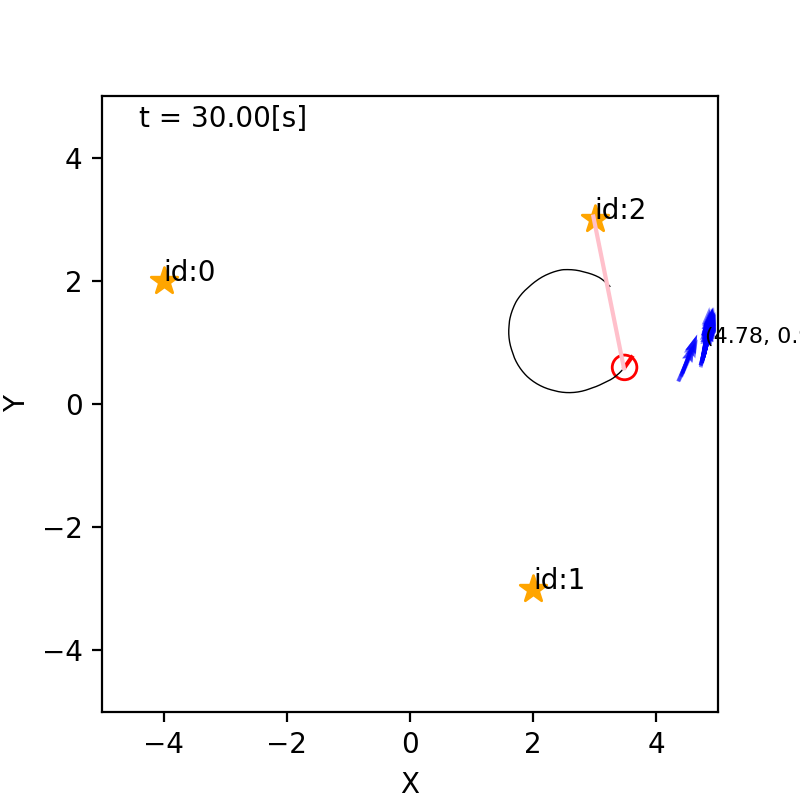

(array([3.24384381, 1.91057913, 2.3191324 ]),
 array([1.32521797, 3.71688373, 0.2325281 ]))

In [5]:
trial(True)

In [ ]:
def trial_phantom(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([0,0,0]).T #np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m, phantom_prob=0.1), agent=a, color="red")
    world.append(r)

    world.draw()
    world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=1)
    
    return (r.pose, pf.ml.pose)

In [ ]:
trial_phantom(True)

In [6]:
if __name__ == '__main__': ###mclglobal1exec
    ok = 0
    for i in range(1000):
        actual, estm = trial(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:", actual, "推定値", estm, "誤差:", diff)
        if diff <= 1.0:
            ok += 1

    ok

0 真値: [ 1.64510358 -4.15325735  6.05426631] 推定値 [-4.30111863 -1.81553408  5.98215674] 誤差: 6.389249453966047
1 真値: [-3.69186036 -1.13885171  4.30454663] 推定値 [ 0.51969267 -1.3905209   5.18772232] 誤差: 4.2190658055170305
2 真値: [2.0464869  2.12370439 4.2711373 ] 推定値 [1.49170953 2.79831608 4.30199143] 誤差: 0.8734293700181998
3 真値: [ 6.42483121 -2.01033798  1.35824368] 推定値 [-1.82796902 -2.76053379  4.66671322] 誤差: 8.286827212597418
4 真値: [1.24052171 0.24174858 4.48853563] 推定値 [1.85899606 0.47712633 4.33889861] 誤差: 0.6617501071831574
5 真値: [-3.06968806  3.26895311  4.40731628] 推定値 [-2.74109721  2.68660618  3.91684696] 誤差: 0.6686552825309524
6 真値: [-1.36075207  1.83976592  6.81454094] 推定値 [-1.71473359  1.03899993  6.88791381] 誤差: 0.8755164667484446
7 真値: [3.65711893 2.25741978 2.41481999] 推定値 [3.94553236 2.61995649 2.8566196 ] 誤差: 0.46326576925096385
8 真値: [2.36922778 3.96814754 2.72537361] 推定値 [0.17656985 1.54553511 1.84495038] 誤差: 3.267537266807573
9 真値: [-0.46810129 -2.1319215   4.18962109] 推

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


19 真値: [-0.9855602   2.86671692  7.13587508] 推定値 [0.31627387 1.76000573 7.58749391] 誤差: 1.7086783248907063
20 真値: [ 3.53196368 -4.35576052  6.02987325] 推定値 [-2.70153456  6.54012797  1.8803363 ] 誤差: 12.552963236884453
21 真値: [ 1.16328896 -2.14845686  7.05136718] 推定値 [ 1.23175307 -2.2073665   6.99830632] 誤差: 0.09031987606546019
22 真値: [ 3.50166818 -1.59037463  2.72081453] 推定値 [-1.30630049  6.24102975  6.59968805] 誤差: 9.189529767505038
23 真値: [-2.43432801 -1.55604907  2.43070587] 推定値 [-2.52945731 -1.01472903  2.56412387] 誤差: 0.5496152876707693
24 真値: [-5.11774039 -2.03065439  6.30575923] 推定値 [-6.60733526 -2.06859883 -0.31078879] 誤差: 1.4900780643784546
25 真値: [-0.47819383 -1.9021438   5.88003572] 推定値 [-0.04215829 -2.40979743  5.97876327] 誤差: 0.6692078896026455
26 真値: [-3.84485833  4.21191938  4.16735021] 推定値 [-3.53082798 -1.08591028  7.51984325] 誤差: 5.307128613371909
27 真値: [ 0.43805588 -4.45712     2.56302078] 推定値 [ 0.1869409  -2.92545265  1.82030833] 誤差: 1.5521158387352019
28 真値: [-3.516

95 真値: [0.68509365 2.5052762  2.16221123] 推定値 [1.25074125 2.33923635 2.1937712 ] 誤差: 0.5895137358528355
96 真値: [-2.32640056 -5.00945115  8.31376038] 推定値 [-2.21808956 -1.44156692  7.60864263] 誤差: 3.569527858790033
97 真値: [-0.87679707 -3.4772742   7.96725401] 推定値 [-1.33427618 -3.41195684  1.47098475] 誤差: 0.4621184858283972
98 真値: [-1.7086236  -5.54629124  7.13620942] 推定値 [ 2.37403248  1.27327763 11.09136702] 誤差: 7.948245101042549
99 真値: [-1.63337684 -2.24911761  3.30120157] 推定値 [ 1.3038108  -0.52894029 10.18411204] 誤差: 3.403833317457381
100 真値: [-2.92664437  4.85312482  6.28705829] 推定値 [-0.86137874 -0.24941073 10.81538319] 誤差: 5.504651775520259
101 真値: [-0.5508072  -1.03967752  3.50577221] 推定値 [0.04620969 4.62676383 4.82717247] 誤差: 5.697805424687749
102 真値: [ 0.7023852  -4.76556736  1.49077835] 推定値 [-0.71742324 -2.45398356  6.62221693] 誤差: 2.712798492355456
103 真値: [-2.21663229 -5.83319921  6.96205691] 推定値 [-0.16857717  3.39622104  5.06700942] 誤差: 9.453926590679039
104 真値: [-4.73869416  

171 真値: [-2.90507665 -0.11209146  4.39981918] 推定値 [-1.05102388  1.32019361  5.37924062] 誤差: 2.342851295935612
172 真値: [ 1.08793834 -3.86628325  7.15689524] 推定値 [ 1.28105578 -4.35686913  7.49666872] 誤差: 0.5272275122979633
173 真値: [ 4.59517782 -0.39027036  8.66693887] 推定値 [ 1.4821416  -1.13703855  7.8205417 ] 誤差: 3.201352409061604
174 真値: [-1.0977896   2.71906754  3.57559074] 推定値 [-0.93605959  2.75416637  3.53377007] 誤差: 0.16549477620136718
175 真値: [ 1.55029367 -1.2566646   2.66458814] 推定値 [-1.95919963  0.60306683  1.70764647] 誤差: 3.9717935687208037
176 真値: [-1.98362309 -1.15602036  3.84820391] 推定値 [-2.36619689 -1.06729701  4.12922088] 誤差: 0.3927270639165885
177 真値: [ 2.43632928 -4.39319861  7.39084645] 推定値 [-3.56003232  3.77177225  5.21640776] 誤差: 10.130306091886577
178 真値: [-0.88027789  4.51418356  5.96999599] 推定値 [-1.00748972  4.59471723  5.93484482] 誤差: 0.1505606882469881
179 真値: [ 2.98180755 -0.09570958  3.50732334] 推定値 [0.83472106 0.77275578 4.10080946] 誤差: 2.3160769586056578
180 真

246 真値: [-5.46750147  1.33605627  5.69127712] 推定値 [ 4.29231029 -4.87152745  7.03375165] 誤差: 11.566677189652541
247 真値: [-3.60922507  2.13429549  5.16607024] 推定値 [-3.58961883  2.04546857  5.31337979] 誤差: 0.0909649752356727
248 真値: [-1.19903616 -1.48523379  5.05836341] 推定値 [-1.49822099 -2.23348046  5.30157897] 誤差: 0.805844054233754
249 真値: [0.96305541 5.04194524 5.09251453] 推定値 [-0.56056097  0.36992716  6.54009861] 誤差: 4.914179466363796
250 真値: [-2.78385931  4.30136113  3.76459654] 推定値 [-1.88989376  2.70868911  3.07769163] 誤差: 1.8264113883145219
251 真値: [ 0.22705878 -5.00237734  3.14986   ] 推定値 [ 4.7782053  -3.73401831  4.54377778] 誤差: 4.724581392637144
252 真値: [ 7.22168206 -1.49217983  1.39149373] 推定値 [-2.54424682 -0.94216543  4.59701905] 誤差: 9.781404942267866
253 真値: [ 1.18417126 -1.61760332  5.14755215] 推定値 [-6.43302759 -3.32750271  0.0872837 ] 誤差: 7.806758236437969
254 真値: [-1.66942617 -4.24534551  5.97760749] 推定値 [ 5.43295219 -1.16589029  0.43236752] 誤差: 7.741241683444025
255 真値: [-

321 真値: [3.29816755 1.85800496 6.91583145] 推定値 [0.61018598 1.4557021  1.24848256] 誤差: 2.71792063117796
322 真値: [-1.33640988  1.441918    6.98962306] 推定値 [-1.22405896  1.65918478  6.87973   ] 誤差: 0.2445967733708086
323 真値: [ 2.14967755 -2.31916977  3.93186768] 推定値 [ 1.47478949 -2.74089358  5.12682182] 誤差: 0.79581710664976
324 真値: [ 0.48131858 -4.09783243  6.59591508] 推定値 [ 2.68782993 -1.25329456 10.31166636] 誤差: 3.6000122217473667
325 真値: [-3.50407799 -4.46430036  5.67611103] 推定値 [-2.17614076 -0.79947007  4.90386198] 誤差: 3.8979992680200923
326 真値: [ 0.73706578 -2.08537967  6.46413642] 推定値 [ 0.53742481 -1.74692177  0.07341099] 誤差: 0.3929507228046302
327 真値: [3.17451662 3.64346911 8.22266233] 推定値 [-3.1468742  -1.34683491 10.46356148] 誤差: 8.053764096970074
328 真値: [ 1.21931777 -1.68969134  5.23762039] 推定値 [ 1.10473972 -2.30766274  5.55042099] 誤差: 0.6285036070721284
329 真値: [-0.72674482  0.39033537  5.09548407] 推定値 [-3.18430134 -0.83193892 11.90635664] 誤差: 2.7447292225074658
330 真値: [ 1.800

397 真値: [-5.61515987 -3.829433    5.89330828] 推定値 [-2.44057646 -2.92571881  6.09175358] 誤差: 3.3007088938281304
398 真値: [-4.72681979 -0.89226373  6.16616224] 推定値 [-4.78918367 -0.16666922  5.95247577] 誤差: 0.7282696217231996
399 真値: [3.51570716 3.96896205 2.75072206] 推定値 [ 6.33825907 -7.0598517   7.13541227] 誤差: 11.384266862841589
400 真値: [ 2.04104183 -4.81622712  8.28661769] 推定値 [ 0.96876953 -1.19218958 -0.69114724] 誤差: 3.779340678008179
401 真値: [-0.59853285  2.33790514  4.06100288] 推定値 [-1.10960475  2.18170662 10.36730571] 誤差: 0.5344085169648537
402 真値: [-3.8515499   4.06374845  5.8915384 ] 推定値 [-2.30755538  0.6053563   3.59932439] 誤差: 3.7873995471479676
403 真値: [-5.14361267 -1.01587703  6.60387232] 推定値 [-0.36979529  3.25097816  2.55922203] 誤差: 6.402763901618227
404 真値: [ 0.3739319  -2.5795583   7.29150079] 推定値 [ 0.58046708 -1.82698926  6.6351829 ] 誤差: 0.7803953758852619
405 真値: [-3.85474335 -4.54823882  6.80026621] 推定値 [-3.09953763 -4.29834806  6.52433788] 誤差: 0.7954753742524324
406 真値

472 真値: [ 3.29050689 -0.67589831  7.95478232] 推定値 [ 2.27802963 -0.53895724  7.69904858] 誤差: 1.0216961611767659
473 真値: [-3.74739263e-03 -1.63364660e+00  7.25159934e+00] 推定値 [ 0.12378063 -1.3355707   7.24944913] 誤差: 0.32421078775225615
474 真値: [0.31027291 4.89752553 3.99095037] 推定値 [-5.11336694  5.73997887  5.26993896] 誤差: 5.488678974131228
475 真値: [ 3.63203003 -2.02067464  8.50764748] 推定値 [-2.43529016  2.48672016  6.90077852] 誤差: 7.558371655991114
476 真値: [-2.51390689 -0.09221871  4.26829114] 推定値 [-2.63797426  0.38927674  4.12084557] 誤差: 0.4972228647788449
477 真値: [5.36576986 3.08268895 8.54576876] 推定値 [-4.36692223 -1.94372118  6.06188816] 誤差: 10.953999008194087
478 真値: [ 3.43433065 -1.06598832  2.35175814] 推定値 [ 3.01340857 -0.75053879  2.17045125] 誤差: 0.5260074108391406
479 真値: [-4.00041496  3.13666878  6.97905906] 推定値 [-3.01577375  1.73197679  5.01570849] 誤差: 1.7154235320035456
480 真値: [0.54684921 0.77792943 8.72537349] 推定値 [1.04868562 1.23001572 8.72850197] 誤差: 0.6754419229581649
48

548 真値: [-0.68150787  2.70890394  4.85438968] 推定値 [-0.58111283  2.50681651  4.72563413] 誤差: 0.22565126656855058
549 真値: [ 0.3098466  -0.49231596  4.36363576] 推定値 [0.56025647 0.0340134  4.09912145] 誤差: 0.5828616485438572
550 真値: [0.24751165 4.39390166 3.73526077] 推定値 [-3.64678219 -2.50372214  1.75904075] 誤差: 7.921031409040432
551 真値: [-0.70579349  4.39750258  6.08986091] 推定値 [-0.41984121  4.69919653  5.9709758 ] 誤差: 0.41567769731415716
552 真値: [-0.23137888 -5.92921856  6.65626469] 推定値 [-1.27491931 -3.4044696   5.82600715] 誤差: 2.731910310814418
553 真値: [0.99677063 4.39971584 3.8800302 ] 推定値 [-1.13855204 -2.37279224  2.43210612] 誤差: 7.101159665915597
554 真値: [-0.33187649  2.50927409  2.35842387] 推定値 [ 2.88289758 -7.98447871 13.86765519] 誤差: 10.975136448432648
555 真値: [-4.9584267   3.46485323  4.75577605] 推定値 [-2.4263501   3.11055524  3.21259897] 誤差: 2.5567438164305223
556 真値: [-5.52675089 -3.95420726  6.02945367] 推定値 [-0.70292834  6.1185958   9.31268428] 誤差: 11.16828659672616
557 真値: [-2.

624 真値: [-3.01406675  3.89176237  5.1657575 ] 推定値 [-5.11190229 -2.81037026  2.30610147] 誤差: 7.022784046510449
625 真値: [-3.19943773 -2.89891629  8.78468004] 推定値 [5.31204676 0.83479739 3.72323129] 誤差: 9.294406179861879
626 真値: [1.48133864 1.45933141 3.92723908] 推定値 [0.61458604 2.42801249 4.07407078] 誤差: 1.2998473356457716
627 真値: [-2.97572293  3.65732581  6.16807341] 推定値 [-3.39384172  0.12934656  3.53867673] 誤差: 3.5526695461858098
628 真値: [-1.35657993  5.65416564  4.03132751] 推定値 [-1.14600683  5.97751409  4.00558683] 誤差: 0.38586948339384314
629 真値: [ 1.28737016 -4.91145802  6.54502368] 推定値 [ 6.7974214  -1.69786034  2.93549549] 誤差: 6.378704776294538
630 真値: [-1.22633299 -1.81449346  2.56788626] 推定値 [-1.10498861 -1.68861439  8.87654249] 誤差: 0.17484278784324184
631 真値: [ 0.21244517 -1.43221203  4.71052434] 推定値 [-0.05491624 -1.74393986  4.84070837] 誤差: 0.4106779330893978
632 真値: [-2.05501671  5.78367326  3.32097746] 推定値 [-2.19525542  4.21729534  3.00903937] 誤差: 1.572643214370891
633 真値: [-2.

700 真値: [5.47741892 5.02520164 3.46252142] 推定値 [-0.67884745 -3.28955014  7.0360401 ] 誤差: 10.345758201638656
701 真値: [-2.54090213  3.39676584  5.81298811] 推定値 [-2.18139152  3.81935949  5.67596346] 誤差: 0.5548272471036844
702 真値: [1.94662339 3.7305636  2.82889754] 推定値 [ 2.3833415   1.88375012 10.64476361] 誤差: 1.8977467562829682
703 真値: [-1.45012483  0.22755544  1.79218519] 推定値 [-1.32364396  0.36924291  8.10890608] 誤差: 0.18992826804801052
704 真値: [-1.68758965 -5.70768275  6.05765431] 推定値 [-3.38495759 -3.06154574  5.3730304 ] 誤差: 3.1437396555504735
705 真値: [2.36135675 2.02384023 8.12717347] 推定値 [2.48758714 2.06504375 1.86486435] 誤差: 0.13278494786642558
706 真値: [-3.39463885  0.17847085  5.52273812] 推定値 [-3.66673602  1.50571587  3.62405967] 誤差: 1.354849147849349
707 真値: [-3.14058587 -1.41170818  5.06617332] 推定値 [-2.60232835 -1.10588786  4.88536244] 誤差: 0.6190696475896568
708 真値: [-2.17275897 -2.01653702  3.26120348] 推定値 [ 2.17303221 -0.62464814 10.22723981] 誤差: 4.563250556386372
709 真値: [-2.1

775 真値: [-3.0120487  -3.10644393  2.69005711] 推定値 [-1.69204541 -2.50368343  9.28130315] 誤差: 1.4511129814276722
776 真値: [-4.57551001  0.40567121  7.40382381] 推定値 [-2.78687661  2.74705404  3.59815248] 誤差: 2.946401707289697
777 真値: [-3.35621788  4.51341678  3.41403687] 推定値 [-0.07323945 -2.52446886  6.58340815] 誤差: 7.765937266400122
778 真値: [-3.28730488  1.52866839  3.08275851] 推定値 [ 3.50735289 -0.41667822  9.92413223] 誤差: 7.067655035245202
779 真値: [3.44050919 4.71482395 4.86051811] 推定値 [2.03962006 1.34038419 7.7426917 ] 誤差: 3.653674048532207
780 真値: [-0.75241024  2.25029584  4.95365525] 推定値 [-1.17177635  1.64054011  4.92026781] 誤差: 0.7400472839526495
781 真値: [-1.6158347   2.24108032  8.05153487] 推定値 [-2.45629311  2.21955944  8.26835861] 誤差: 0.8407339044871338
782 真値: [0.02012297 0.21496958 6.00503012] 推定値 [ 0.11358139 -0.08589166  6.01651101] 誤差: 0.3150427961871737
783 真値: [-2.89664269  1.1392878   4.2838247 ] 推定値 [-2.70370832  1.4337086  10.49126246] 誤差: 0.35200465678652004
784 真値: [-1.5

850 真値: [-2.09495871  0.18791046  3.23082755] 推定値 [-0.87591256  1.73334615  3.85070667] 誤差: 1.9683609888227722
851 真値: [-2.13941788 -2.21259619  4.03203522] 推定値 [-2.0917807  -1.70775918  3.97864434] 誤差: 0.5070795898509624
852 真値: [-1.40752549  4.49562377  4.83124798] 推定値 [-2.03580515  0.07855605  3.26397631] 誤差: 4.461526938665176
853 真値: [-1.15834395  0.97484224  4.5682281 ] 推定値 [-1.18199643  0.46179679  4.65323677] 誤差: 0.5135903671456802
854 真値: [-2.33465901 -2.14233336  5.68049784] 推定値 [-1.93735492 -2.63691158 -0.52775116] 誤差: 0.6343958990490728
855 真値: [-3.08109096  6.04974344  3.99256298] 推定値 [-3.41860968 -2.58922339  7.55032846] 誤差: 8.64555763552069
856 真値: [2.22451024 2.76378198 2.90681766] 推定値 [2.24921406 3.13205403 8.25204403] 誤差: 0.3690996930174358
857 真値: [-5.18853792 -1.19013406  6.3982339 ] 推定値 [-0.48631805  1.1137931   7.45870895] 誤差: 5.236310928287656
858 真値: [3.38846556 3.52298106 4.50363817] 推定値 [ 6.25852809 -4.22584745  8.65509682] 誤差: 8.263268251117797
859 真値: [2.1444

926 真値: [-4.38639587 -2.86915481  5.89159405] 推定値 [ 0.99933029 -0.70895635  7.21281039] 誤差: 5.80280136427495
927 真値: [-1.29494903 -3.2381638   5.18360199] 推定値 [-4.7902518  -0.43555459  4.8258385 ] 誤差: 4.480151768917699
928 真値: [-3.20139637  0.57012599  5.6164427 ] 推定値 [-3.82882997  0.48456069  5.48105145] 誤差: 0.6332411354249761
929 真値: [ 1.15745573 -5.67314526  6.67923756] 推定値 [-1.06622683 -1.46853887  5.00150114] 誤差: 4.756414514250221
930 真値: [ 4.69616245 -3.8626169   4.2859453 ] 推定値 [-0.36465016 -0.07510554  6.70158414] 誤差: 6.321160231887786
931 真値: [-2.32557076  4.42843841  3.21330359] 推定値 [-0.6728074  -0.64079169  2.35149175] 誤差: 5.331859013272516
932 真値: [1.59765425 5.27337672 3.68372821] 推定値 [-2.33184525 -2.75061499  5.69171297] 誤差: 8.93450666081665
933 真値: [-2.48845678 -0.86189356  5.15051581] 推定値 [-2.25270785 -0.84025974  5.14184649] 誤差: 0.2367394705011492
934 真値: [ 0.08065484 -2.59503775  7.26741165] 推定値 [-0.64578    -1.79122164  7.02767856] 誤差: 1.0834334012208477
935 真値: [0.7

In [7]:
ok

334